По замыслу A/B-теста контрольной группе (`control`) должна была показываться старая версия лендинга — `old_page`; экспериментальной группе (`treatment`) должна была показываться новая версия лендинга — `new_page`.

Вам следует:
1. понять структуру данных, провести EDA и выбрать метрику, с которой будете работать;
2. проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);
3. сформулировать нулевую и альтернативную гипотезы на основании выбранной метрики;
4. выбрать и обосновать статистический тест;
5. решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
6. оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
7. провести дополнительный анализ при необходимости (например, с помощью [bootstrap](https://www.geeksforgeeks.org/maths/bootstrap-method/?utm_source=chatgpt.com)  или через анализ чувствительности);
- сформулировать рекомендации и бизнес-инсайты по результатам эксперимента.

**Важно**: это лишь возможные шаги для вашего исследования и воспринимать их следует как подсказки. Ваша центральная задача в любом случае представлена в общем виде — осуществить качественный и полный анализ результатов проведенного AB-тестирования.



Датасет состоит из пяти столбцов:

* `user_id` — уникальный идентификатор пользователя;

* `timestamp` — время посещения пользователем страницы;

* `group` — группа эксперимента, к которой был случайно отнесён пользователь:

  *   `control` — контрольная группа,
  *   `treatment` — экспериментальная группа;

* `landing_page` — версия лендинга, которую увидел пользователь:

  *   `old_page` — старая версия страницы,
  *   `new_page` — новая версия страницы;

* `converted` — бинарный признак, показывающий, совершил ли пользователь целевое действие (целевым действием является регистрация на курс).








In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.power import NormalIndPower
from scipy.stats import beta

## 1
понять структуру данных, провести EDA и выбрать метрику, с которой будете работать;

In [ ]:
df = pd.read_csv('data_ab.csv', sep=',')
print(df.shape)
df.head()

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [ ]:
print("Пропущенные значения:")
print(df.isnull().sum())
print(f"Дубликатов user_id: {df['user_id'].duplicated().sum()}")

Пропущенные значения:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
Дубликатов user_id: 3894


В данных отсутствуют пропущенные значение во всех столбца, что свидетельствует о полноте собранных данных. Однако было обнаружено 3894 дубликата user_id, что указывает на повторные записи для одних и тех же пользователей. Это могло быть связано, например, с повторными посещениями или техническими сбоями в логировании событий и требует дополнительной проверки на корректность учета уникальных пользователей в анализе.

In [ ]:
groups = df['group'].value_counts()
print("Распределение по группам:")
print(groups)

pages = df['landing_page'].value_counts()
print("Распределение по версиям страниц:")
print(pages)

Распределение по группам:
group
treatment    147276
control      147202
Name: count, dtype: int64
Распределение по версиям страниц:
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64


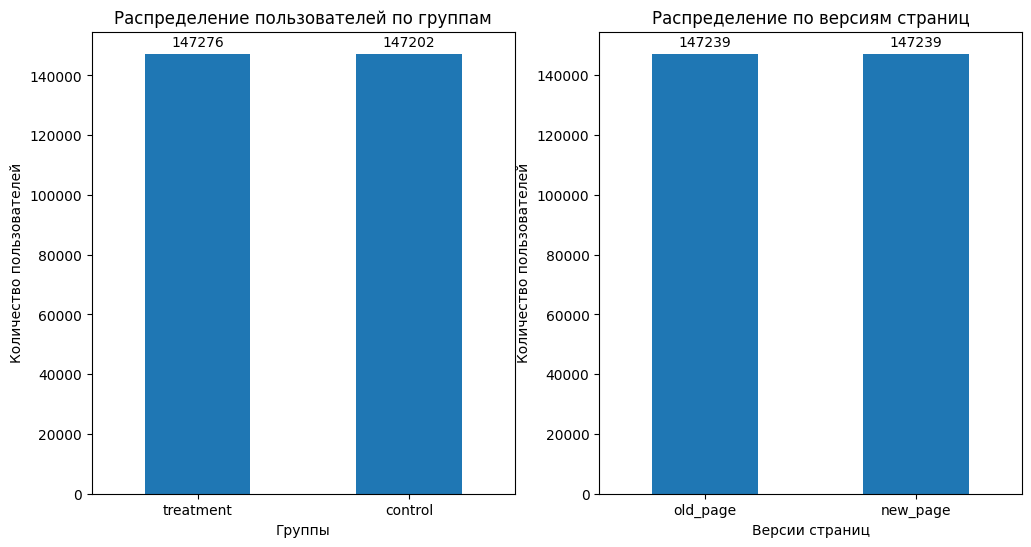

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
ax1 = groups.plot(kind='bar')
plt.title('Распределение пользователей по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Группы')
plt.xticks(rotation=0)

for i, v in enumerate(groups):
    ax1.text(i, v + max(groups)*0.01, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
page_counts = df['landing_page'].value_counts()
ax2 = page_counts.plot(kind='bar')
plt.title('Распределение по версиям страниц')
plt.ylabel('Количество пользователей')
plt.xlabel('Версии страниц')
plt.xticks(rotation=0)

for i, v in enumerate(page_counts):
    ax2.text(i, v + max(page_counts)*0.01, str(v), ha='center', va='bottom')

plt.show()

Данный график и данные показывают, что данные по группам (control/treatment) и версиям страниц (old_page/new_page) распределены сбалансированно:

- Разница между группами составляет всего 74 человека (treatment 147.246 пользователей и control 147.202 пользователя)
- Разница между версиями страниц отсутствует, в каждой части по 147.239 пользователей

Общее количество пользователей в эксперименте - около 294,5 тысяч пользователей

Временные рамки эксперимента:
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:54.460509
Длительность: 21 days 23:59:49.081927


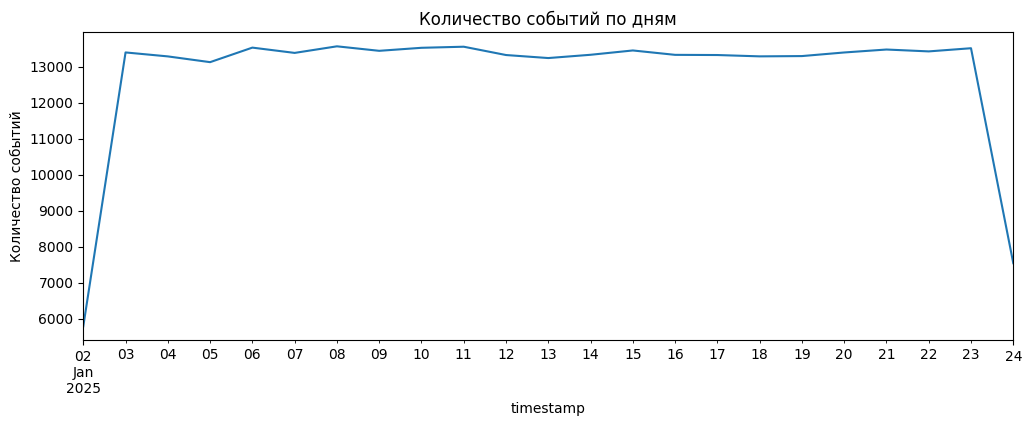

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
print("Временные рамки эксперимента:")
print(f"Начало: {df['timestamp'].min()}")
print(f"Конец: {df['timestamp'].max()}")
print(f"Длительность: {df['timestamp'].max() - df['timestamp'].min()}")

daily_events = df.set_index('timestamp').resample('D').size()
plt.figure(figsize=(12, 4))
daily_events.plot()
plt.title('Количество событий по дням')
plt.ylabel('Количество событий')
plt.show()


Эксперимент проводился со 2 по 24 января 2025 года, его общая продолжительность составила 22 дня, количество событий на протяжении периода было на стабильно высоком уровне (около 13.000 событий в денб), без резких всплесков или провалов, что свидетельствует об отсутствии техническиъ сбоев в сборе данных.

На графике видно, что количесво событий резко возрастает в первый день и заметно снижается в последний день эксперимента. Скорее всего, это связано с техническими особенностями старта и остановки сбора метрик.

In [1]:
print(f"Общая конверсия: {df['converted'].mean()}")

con1 = df.groupby('group')['converted'].agg(['mean', 'count'])
print("Конверсия по группам:")
print(con1)

con2 = df.groupby('landing_page')['converted'].agg(['mean', 'count'])
print("Конверсия по версиям страниц:")
print(con2)

NameError: name 'df' is not defined

Общая конверсия данных составила около 11,97%. При сравнении групп наблюдается небольшое различие: в контрольной группе (control) конверсия составила 12,04%, а в экспериментальное (treatment) - 11,89%, что указывает на незначительное  снижение конверсии в новым воздействием.

Этот результат согласуется с рапределением по версиям страниц: польхзователи, попавшие на старую страницу, показали конверсию 12,05%, тогда как попавшие на новую - 11,88%. Разница составила менее 0,2 процентных пунктов.

In [ ]:
df.duplicated(subset=['user_id']).sum()

np.int64(3894)

In [ ]:
tab = pd.crosstab(df['group'], df['landing_page'])
print(tab)

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


При проверке чистоты данных в A/B тестировании были обнаружены некорректные данные: вместо того, чтобы контрольная группа видела только старую версию страниц, а экспериментальная - только новую, произошло смешение данных. 1928 раз пользователель из control-группы попадал на новую страницу и 1965 раз пользователь из treatment-группы попадал на старую страницу.

Это может указывать либо на ошибку в механизме рандомизации и назначения версий, либо на неккоректную запись данных.

Такое смешение нарушает чистоту эксперимента и делает прямое сравнение конверсии групп некорректным, поскольку каждая группа содержит пользователей, увидевших обе версии страницы. Для дальнейшего анализа мы очищаем данные, оставив только корректные пары (control + old_page, treatment + new_page).

In [ ]:
df2 = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

print(f"Финальный размер: {len(df2)}")

Финальный размер: 290585


In [ ]:
tab = pd.crosstab(df2['group'], df2['landing_page'])
print(tab)

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0


In [ ]:
df2[df2.duplicated(subset=['user_id'])==True]

,user_id,timestamp,group,landing_page,converted,date,hour
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0,2025-01-14,2


После очистки данных мы удалили все неккоректные значения и проанализировали оставшиеся записи. При проверке дубликатов выяснилось, что почти все (кроме 1 записи) дубликаты связаны именно с удаленными ошибочными данными. Это подтверждает, что часть пользователей действительно видела две разные версии страницы из-за технических сбоев или повторных посещений. После очстки остался лишь один случай дублирования записей, который мы отдельно проверим на предмет корректности.

In [ ]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,date,hour
1899,773192,2025-01-09 05:37:58.781806,treatment,new_page,0,2025-01-09,5
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0,2025-01-14,2


In [ ]:
df2 = df2.drop_duplicates(subset='user_id', keep='last')

После анализа дубликата (user_id 773192, два события с разным временем), мы вручную удаляем первую запись (9 января 2025), оставляя более позднюю версию. Это решение основано на принципе приоритета актуальных данных: последнее зафиксированное взаимодействие пользователя с системой является наиболее релевантным для анализа.

Однако можем заметить, что в принципе пользователь не поменял своего мнения и значение конверсии не изменилось.

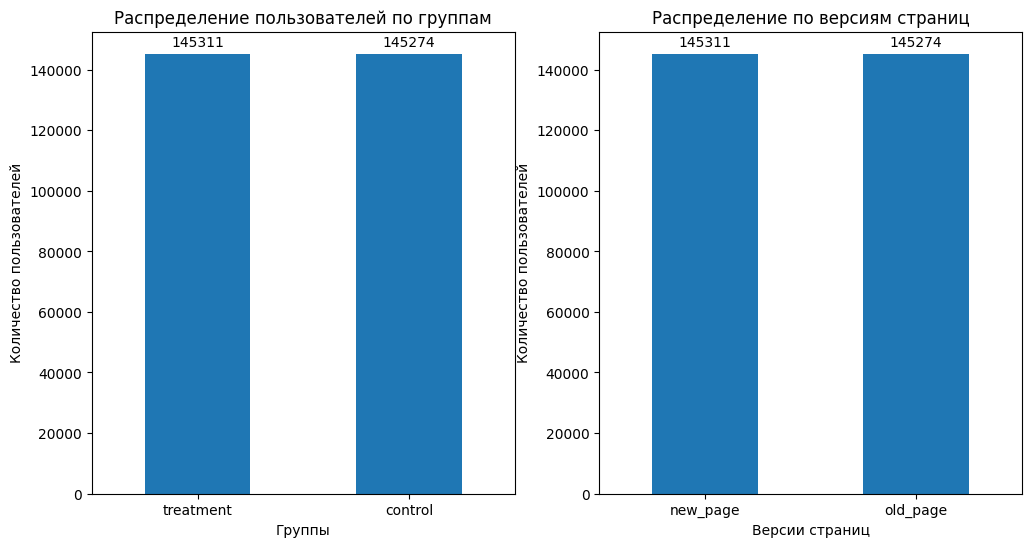

In [ ]:
plt.figure(figsize=(12, 6))

groups2 = df2['group'].value_counts()

plt.subplot(1, 2, 1)
ax1 = groups2.plot(kind='bar')
plt.title('Распределение пользователей по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Группы')
plt.xticks(rotation=0)

for i, v in enumerate(groups2):
    ax1.text(i, v + max(groups2)*0.01, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
page_counts = df2['landing_page'].value_counts()
ax2 = page_counts.plot(kind='bar')
plt.title('Распределение по версиям страниц')
plt.ylabel('Количество пользователей')
plt.xlabel('Версии страниц')
plt.xticks(rotation=0)

for i, v in enumerate(page_counts):
    ax2.text(i, v + max(page_counts)*0.01, str(v), ha='center', va='bottom')

plt.show()

Временные рамки эксперимента:
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:54.460509
Длительность: 21 days 23:59:49.081927


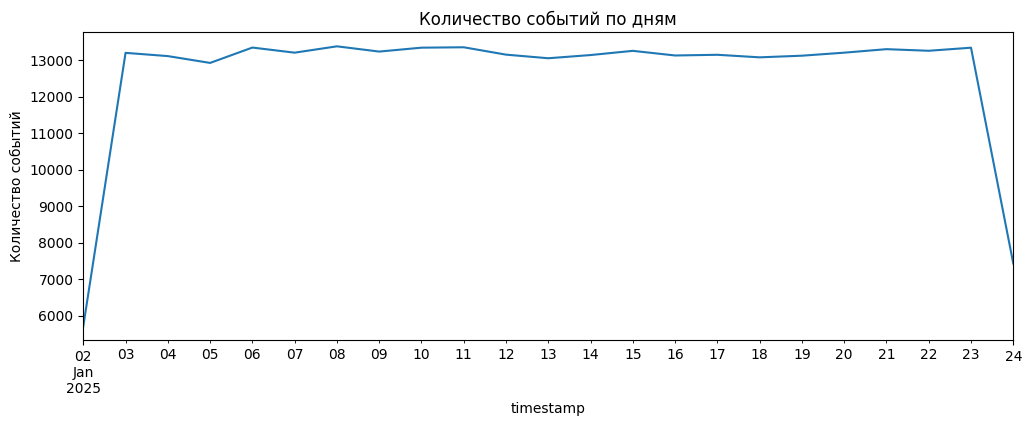

In [ ]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
print("Временные рамки эксперимента:")
print(f"Начало: {df2['timestamp'].min()}")
print(f"Конец: {df2['timestamp'].max()}")
print(f"Длительность: {df2['timestamp'].max() - df2['timestamp'].min()}")

daily_events = df2.set_index('timestamp').resample('D').size()
plt.figure(figsize=(12, 4))
daily_events.plot()
plt.title('Количество событий по дням')
plt.ylabel('Количество событий')
plt.show()

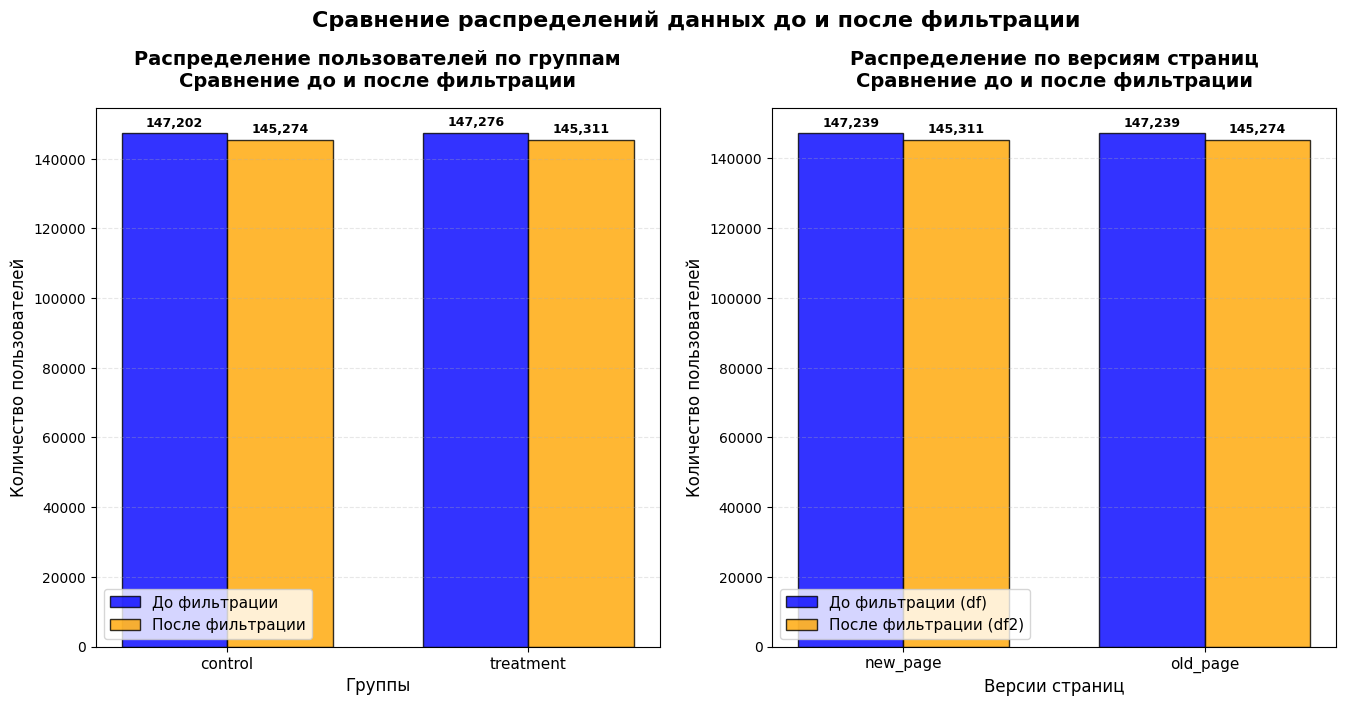

In [ ]:
groups_df1 = df['group'].value_counts()
groups_df2 = df2['group'].value_counts()

pages_df1 = df['landing_page'].value_counts()
pages_df2 = df2['landing_page'].value_counts()

all_groups = sorted(set(list(groups_df1.index) + list(groups_df2.index)))
all_pages = sorted(set(list(pages_df1.index) + list(pages_df2.index)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

x = np.arange(len(all_groups))
width = 0.35

values_df1_groups = [groups_df1.get(group, 0) for group in all_groups]
values_df2_groups = [groups_df2.get(group, 0) for group in all_groups]

bars1_groups = ax1.bar(x - width/2, values_df1_groups, width, label='До фильтрации', color='blue', alpha=0.8, edgecolor='black')
bars2_groups = ax1.bar(x + width/2, values_df2_groups, width, label='После фильтрации', color='orange', alpha=0.8, edgecolor='black')

ax1.set_title('Распределение пользователей по группам\nСравнение до и после фильтрации', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Количество пользователей', fontsize=12)
ax1.set_xlabel('Группы', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(all_groups, rotation=0, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, axis='y', alpha=0.3, linestyle='--')

for bars in [bars1_groups, bars2_groups]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

x_pages = np.arange(len(all_pages))

values_df1_pages = [pages_df1.get(page, 0) for page in all_pages]
values_df2_pages = [pages_df2.get(page, 0) for page in all_pages]

bars1_pages = ax2.bar(x_pages - width/2, values_df1_pages, width, label='До фильтрации (df)', color='blue', alpha=0.8, edgecolor='black')
bars2_pages = ax2.bar(x_pages + width/2, values_df2_pages, width, label='После фильтрации (df2)', color='orange', alpha=0.8, edgecolor='black')

ax2.set_title('Распределение по версиям страниц\nСравнение до и после фильтрации', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Количество пользователей', fontsize=12)
ax2.set_xlabel('Версии страниц', fontsize=12)
ax2.set_xticks(x_pages)
ax2.set_xticklabels(all_pages, rotation=0, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')

for bars in [bars1_pages, bars2_pages]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')


fig.suptitle('Сравнение распределений данных до и после фильтрации', fontsize=16, fontweight='bold', y=1.02)

plt.show()

На основе представленных графиков видно, что фильтрация данных была проведена достаточно сбалансированнно. После очистки общее количество данных в каждой группе (control/treatment и old_page/new_page) сократилось примерно на 2 000 человек, сокращение произошло практически пропорционально в обеих группах, что сохранило исходный баланс эксперимента.

Общее количество записей после очистки составляет 290,5 тыс.

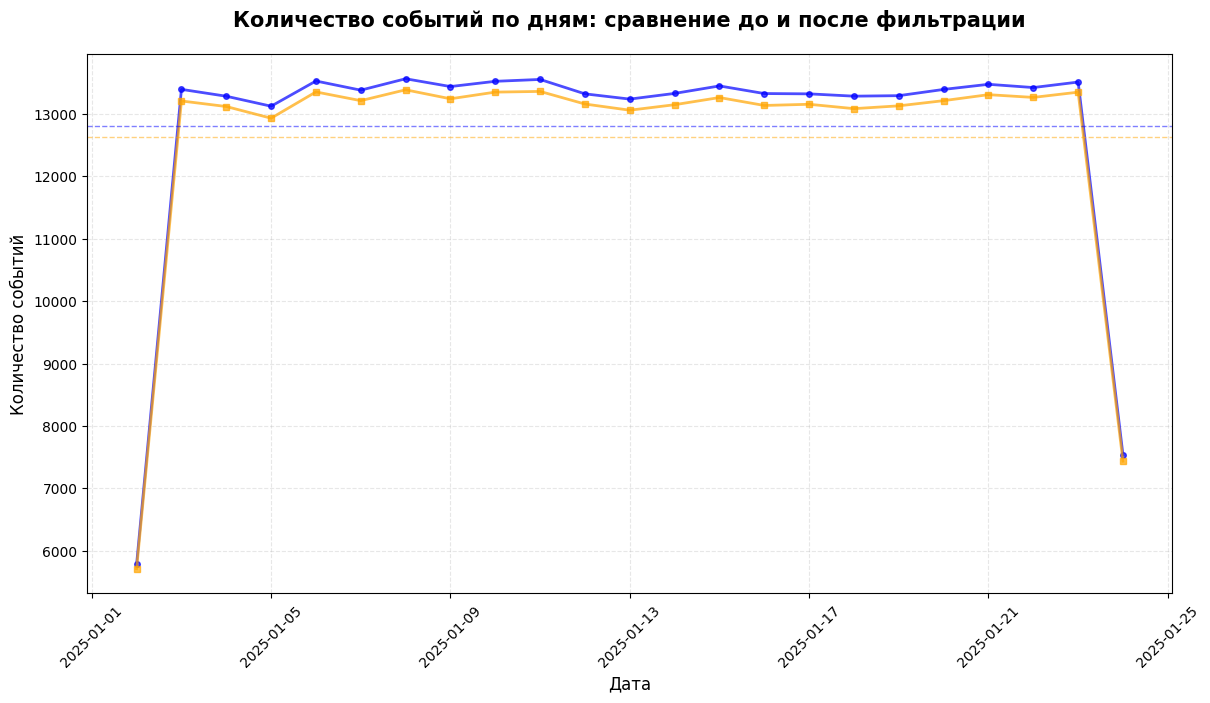

In [ ]:
daily_events_before = df.set_index('timestamp').resample('D').size()
daily_events_after = df2.set_index('timestamp').resample('D').size()

all_dates = pd.date_range(start=min(daily_events_before.index.min(), daily_events_after.index.min()),
                          end=max(daily_events_before.index.max(), daily_events_after.index.max()),
                          freq='D')

comparison_df = pd.DataFrame(index=all_dates)
comparison_df['До фильтрации'] = daily_events_before
comparison_df['После фильтрации'] = daily_events_after
comparison_df = comparison_df.fillna(0)

plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df['До фильтрации'], label='До фильтрации (df)', color='blue', linewidth=2, alpha=0.7, marker='o', markersize=4)
plt.plot(comparison_df.index, comparison_df['После фильтрации'], label='После фильтрации (df2)', color='orange', linewidth=2, alpha=0.7, marker='s', markersize=4)

plt.title('Количество событий по дням: сравнение до и после фильтрации', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Количество событий', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')

mean_before = comparison_df['До фильтрации'].mean()
mean_after = comparison_df['После фильтрации'].mean()

plt.axhline(y=mean_before, color='blue', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(y=mean_after, color='orange', linestyle='--', alpha=0.5, linewidth=1)

plt.show()

Анализ временного ряда показывает, что фильтрация данных не нарушила общую динамику трафика в экперименте. Количество событий после очистки снизилось пропорционально удаленным записям, но форма исходного графика сохранилась.

Сохранение формы графика указывает на то, что большинство удаленных записей (по совместительству дубликатов) были равномерно распределены по массиву, а не сконцентрированы в конкретные дни или периоды. Возможно, удаленные значения в основном представляли собой технические дубликаты или некорректные записи.

In [ ]:
print(f"Общая конверсия: {df2['converted'].mean()}")

con1 = df2.groupby('group')['converted'].agg(['mean', 'count'])
print("Конверсия по группам:")
print(con1)

con2 = df2.groupby('landing_page')['converted'].agg(['mean', 'count'])
print("Конверсия по версиям страниц:")
print(con2)

Общая конверсия: 0.11959667567149027
Конверсия по группам:
               mean   count
group                      
control    0.120386  145274
treatment  0.118807  145311
Конверсия по версиям страниц:
                  mean   count
landing_page                  
new_page      0.118807  145311
old_page      0.120386  145274


Если сравнивать конверсию с неочищенными данными, то она почти не изменилась: было ~11,966%, а стало ~11,959%. Конверсия в контрольной группе осталась на уровне ~12,04%, а в экспериментальной - на уровне ~11,89%. Незначительные изменения в конверсиях и почти идентичное соотношение групп подтверждают, что удаление неккоректных записей и дубликатов не повлияло на итоговую картину эффективности тестируемых изменений.

Для работы мы выбираем метрику **converted**. Она является оптимальной для данного A/B-теста, так как полностью соответствует ключевой бизнес-цели: максимизации регистраций на курс. Это прямой и однозначный показатель эффективности лендинга, который измеряет, какая доля пользователей совершает целевое действие.

С точки зрения анализа, converted обладает рядом важных преимуществ: как бинарная метрика она идеально подходит для применения статистических критериев, таких как z-тест или критерий хи-квадрат, что обеспечивает надежную проверку гипотез. Кроме того, ее простота и наглядность делают результаты понятными дял всех заинтересованных сторон, а стандартность метрики позволяет легко внедрять ее в процессы мониторинга и сравнить с будущими тестами.

## 2
Проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);

/tmp/ipython-input-3136434234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] = df2['timestamp'].dt.date


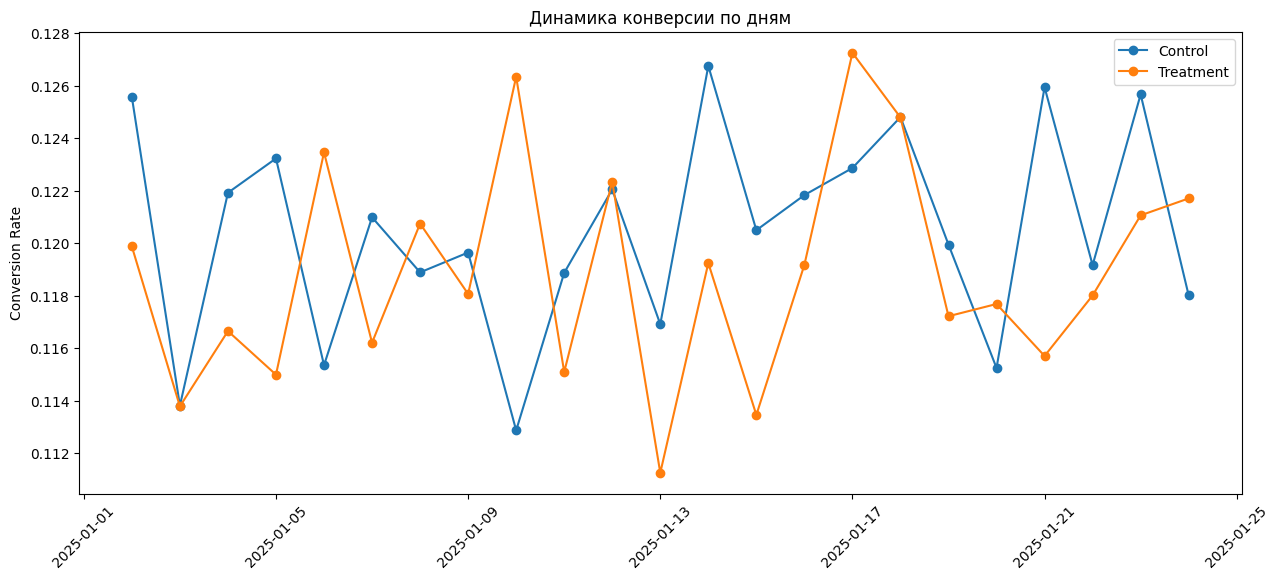

In [ ]:
df2['date'] = df2['timestamp'].dt.date
daily_conversion = df2.groupby(['date', 'group'])['converted'].mean().unstack()

plt.figure(figsize=(15, 6))
plt.plot(daily_conversion.index, daily_conversion['control'], label='Control', marker='o')
plt.plot(daily_conversion.index, daily_conversion['treatment'], label='Treatment', marker='o')
plt.title('Динамика конверсии по дням')
plt.ylabel('Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Для статистической оценки различий между группами в эксперименте часто применяется z-тест для долей. Он позволяет проверить, является ли наблюдаемая разница в конверсии статистически значимой, или она может быть объяснена случайной вариативностью.

Z-тест в A/A-тестировании нужен, чтобы проверить, что система сплитования работает корректно и случайные различия между идентичными группами действительно выглядят случайными — мы ожидаем, что в примерно 5% случаев тест ошибочно покажет «значимость» при α=0.05, и значимые отклонения от этого ожидания (например, 10% ложных срабатываний) сигнализируют о проблемах: либо сплитование смещено, либо есть технические ошибки в логике эксперимента, и такие результаты делают последующие A/B-тесты ненадёжными

In [ ]:
control_data = df2[df2['group'] == 'control']
half_point = len(control_data) // 2

control_1 = control_data.iloc[:half_point]
control_2 = control_data.iloc[half_point:]

conv_1 = control_1['converted'].sum()
conv_2 = control_2['converted'].sum()
n1 = len(control_1)
n2 = len(control_2)

z_stat_aa, p_value_aa = proportions_ztest([conv_1, conv_2], [n1, n2])
print(f"A/A тест - Z-статистика: {z_stat_aa:.4f}, P-значение: {p_value_aa:.4f}")

A/A тест - Z-статистика: 0.2822, P-значение: 0.7778


Результаты A/A-теста, проведенного для контрольной группы, подтверждают корректность работы системного сплитования. Полученная Z-статистика (0,2822) и высокое p-значение (0.7778) указывают на отсутствие статистически значимых различий мужду случайно разделенными частями одной и той же группы. Это означает, что наблюдаемые колебания носят случайный характер, как и ожидалось при уровне значимости α=0,05, что является необходимым условием для валидности последующего A/B-тестирования.

/tmp/ipython-input-3056214474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour'] = df2['timestamp'].dt.hour


<Figure size 1500x800 with 0 Axes>

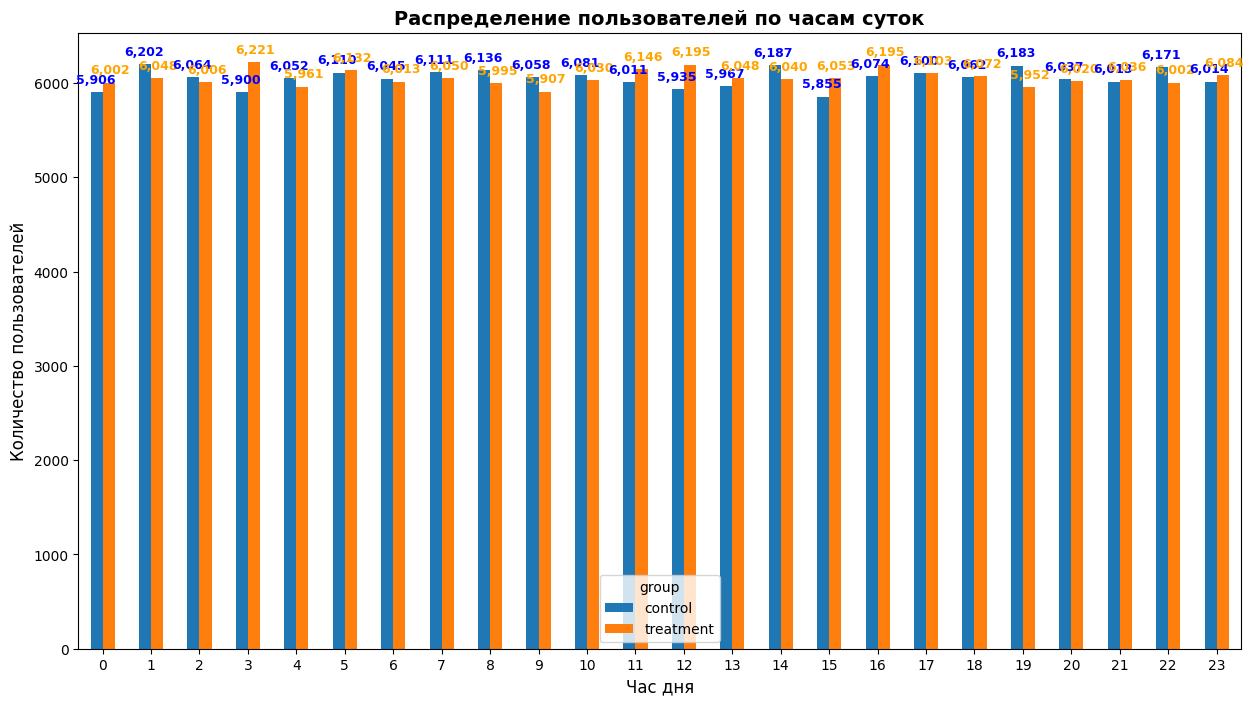

In [ ]:
df2['hour'] = df2['timestamp'].dt.hour
dis = df2.groupby(['hour', 'group']).size().unstack()

plt.figure(figsize=(15, 8))
ax = dis.plot(kind='bar', figsize=(15, 8))

plt.title('Распределение пользователей по часам суток', fontsize=14, fontweight='bold')
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Час дня', fontsize=12)
plt.xticks(rotation=0)

for i in range(len(dis)):
    hour = dis.index[i]
    if 'control' in dis.columns:
        control_value = dis.loc[hour, 'control']
        ax.text(i - 0.15, control_value + max(dis.max()) * 0.01,
                f'{control_value:,}',
                ha='center', va='bottom',
                fontsize=9, color='blue', fontweight='bold')
    if 'treatment' in dis.columns:
        treatment_value = dis.loc[hour, 'treatment']
        ax.text(i + 0.15, treatment_value + max(dis.max()) * 0.01,
                f'{treatment_value:,}',
                ha='center', va='bottom',
                fontsize=9, color='orange', fontweight='bold')

plt.show()

Хи-квадрат тест в A/A-тестировании используется для проверки не только пропорций (как z-тест), но и равномерности распределения пользователей по группам по различным категориальным признакам — устройствам, браузерам, регионам или времени суток; если тест выявляет статистически значимые различия в распределении этих характеристик между группами, это указывает на некорректное сплитование, которое вносит систематическое смещение и ставит под сомнение валидность любых будущих A/B-тестов, проведённых в этой системе.

In [ ]:
from scipy.stats import chi2_contingency

chi1, p_date1, dof1, expected1 = chi2_contingency(df2.groupby(['date', 'group']).size().unstack().fillna(0))
print(f"Хи-квадрат тест на равномерность по дням: p-value = {p_date1}")

chi2, p_hour2, dof2, expected2 = chi2_contingency(df2.groupby(['hour', 'group']).size().unstack().fillna(0))
print(f"Хи-квадрат тест на равномерность по часам: p-value = {p_hour2}")

Хи-квадрат тест на равномерность по дням: p-value = 0.9207631079105322
Хи-квадрат тест на равномерность по часам: p-value = 0.02900771459550439


Результаты хи-квадрат тестов показывают неоднородное распределение пользователей по времени. Значение p-value для дней (0,92) указывает на статистически равномерное распределение трафика по дням недели.

Однако низкое p-value для часов (0.029) свидетельствуюет о значимом неравенстве в распределении пользователей по часам суток. Скорее всего это связано с естественными колебаниями трафика в течение суток или особенностями работы системы распределения в пиковое время. Однако поскольку A/A тест пройден и разница невелика, это не является критичной проблемой для валидности эксперимента.

## 3-5
Сформулировать нулевую и альтернативную гипотезы на основании выбранной метрики;
выбрать и обосновать статистический тест;
решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;

Z-тест - статистический метод для проверки гипотезы о среднем значении в выборке. Его цель: оценить, насколько различие между средним значением выборки и гипотетическим значением, предполгаемым для генеральной совокупности, является статистически значимым.

Нулевая гипотеза (H₀): Конверсия в контрольной и экспериментальной группах не отличается.

Альтернативная гипотеза (H₁): Конверсия в контрольной и экспериментальной группах различается.

In [ ]:
n_control = len(df2[df2['group'] == 'control'])
n_treatment = len(df2[df2['group'] == 'treatment'])
print(n_control, n_treatment)

145274 145310


Мы можем использовать Z-тест для пропорций, потому что выполняются все необходимые условия:

1. Большой объем данных - в каждой группе более 145,000 пользователей, что значительно превышает минимальные требования (n > 30)
2. Условия нормальности распределения выполняются:
* n × p > 5 и n × (1-p) > 5 для обеих групп
* При конверсии ~12% и n > 145,000: 145,000 × 0.12 ≈ 17,400 > 5
3. Независимые наблюдения - после очистки дубликатов каждый пользователь учитывается один раз, группы независимы
4. Случайная выборка - пользователи были рандомизированы в группы, что подтверждено A/A тестом

При таких объемах данных выборочное распределение разности пропорций стремится к нормальному даже при бинарной метрике, что делает Z-тест статистически обоснованным.

Преимущества Z-test:
* Высокая мощность при больших выборках
* Простая интерпретация результатов
* Позволяет построить доверительные интервалы
* Стандартный выбор для A/B тестов с бинарными метриками

Обязательно до начала теста установим значения некоторых параметров

1. Уровень значимости (α). Установленные параметры формируют строгие рамки для нашего анализа. Мы допускаем не более α вероятность ложного обнаружения эффекта.
* α = 0.05 (стандартное значение для бизнес-экспериментов)
* Вероятность ошибки I рода (отклонить H₀, когда она верна)

2. Уровень мощности (1-β). Мощность дает нам уверенность, что если разница в конверсии достигнет MDE, мы с высокой вероятностью ее обнаружим.
* 1-β = 0.8 (стандартное значение)
* Вероятность обнаружить эффект, если он действительно есть

3. Минимальный детектируемый эффект (MDE)
* MDE = 1% (относительное изменение конверсии)
* Или 0.2-0.5% абсолютного изменения (зависит от бизнес-контекста)

Эти критерии будут использованы для проверки достаточности размера выборки и интерпретации p-value в ходе теста.

## 6
Оценить разницу в результатах и сделать выводы о практической значимости эксперимента;

In [ ]:
cr_control = df2[df2['group'] == 'control']['converted'].mean()
cr_treatment = df2[df2['group'] == 'treatment']['converted'].mean()

abs_diff = cr_treatment - cr_control
rel_diff = (cr_treatment - cr_control) / cr_control * 100

print(f"Конверсия control: {cr_control} ({cr_control*100}%)")
print(f"Конверсия treatment: {cr_treatment} ({cr_treatment*100}%)")
print(f"Абсолютная разница: {abs_diff} ({abs_diff*100}%)")
print(f"Относительная разница: {rel_diff}%")

Конверсия control: 0.1203863045004612 (12.03863045004612%)
Конверсия treatment: 0.11880724790277405 (11.880724790277405%)
Абсолютная разница: -0.0015790565976871451 (-0.1579056597687145%)
Относительная разница: -1.31165800315857%


На основе посчитанных данных можно сказать, что практическа значимость эксперимента **отсутствует**. Абсолютная разница в конверсии между новой и старой страницой всего -0,16 процентных пункта, что соответствует снижению на 1,31% в пользу старой версии.

In [ ]:
control_converted = df2[df2['group'] == 'control']['converted'].sum()
treatment_converted = df2[df2['group'] == 'treatment']['converted'].sum()
control_total = len(df2[df2['group'] == 'control'])
treatment_total = len(df2[df2['group'] == 'treatment'])

count = [control_converted, treatment_converted]
nobs = [control_total, treatment_total]
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

Z-статистика: 1.3116
P-значение: 0.1897


Полученная Z-статистика (1,3116 |< 1,96) соответствует p-значению 0,1897, что означает значительно выше установленного уровня значимости α=0,05. Это означает, что у нас **нет достаточных статистических оснований отвергнуть нулевую гипотезу** об отсутствии различий между группами. Наблюдаемое снижение конверсии на 0,16 п.п. можно объяснить случайной вариативностью данных.

In [ ]:
cr_control = control_converted / control_total
cr_treatment = treatment_converted / treatment_total

ci_control = proportion_confint(control_converted, control_total, alpha=0.05, method='normal')
ci_treatment = proportion_confint(treatment_converted, treatment_total, alpha=0.05, method='normal')

def diff_proportion_confint(conv1, n1, conv2, n2, alpha=0.05):
    p1 = conv1 / n1
    p2 = conv2 / n2
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = 1.96
    diff = p2 - p1
    ci_lower = diff - z * se
    ci_upper = diff + z * se
    return ci_lower, ci_upper

ci_diff = diff_proportion_confint(control_converted, control_total,
                                 treatment_converted, treatment_total)

print("Конверсии по группам:")
print(f"Control: {cr_control:.4f} ({cr_control*100:.2f}%)")
print(f"Treatment: {cr_treatment:.4f} ({cr_treatment*100:.2f}%)")
print(f"Разница: {cr_treatment - cr_control:.4f} ({(cr_treatment - cr_control)*100:.2f}%)\n")

print("95% ДИ:")
print(f"Control: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"Treatment: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
print(f"Разница конверсий: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")

Конверсии по группам:
Control: 0.1204 (12.04%)
Treatment: 0.1188 (11.88%)
Разница: -0.0016 (-0.16%)

95% ДИ:
Control: [0.1187, 0.1221]
Treatment: [0.1171, 0.1205]
Разница конверсий: [-0.0039, 0.0008]


Статистическая значимость:
* P-value = 0.1899 > 0.05, высока вероятность случайного возникновения разницы в конверсии из-за естественной вариативности данных
* Доверительный интервал включает ноль, что статистически означает отсутствие значимой статистической разницы, нельзя отклонить нулевую гипотезу.
* Z-статистика = 1.3109 < 1.96 (критическое значение для α=0.05)

Новая версия лендинга не показала значимого улучшения конверсии. Рекомендуется не внедрять изменения и продолжить тестирование других гипотез оптимизации.

## 7
провести дополнительный анализ при необходимости (например, с помощью bootstrap или через анализ чувствительности);

Последовательно проведем bootstrap анализ, анализ чувствительности, анализ мощности и байесовский анализ.

Bootstrap анализ — это метод "перетасовки" данных. Мы много раз случайно выбираем данные из нашей выборки (с возможностью повторения) и каждый раз считаем нужную нам статистику (например, среднее). Так мы получаем множество значений и видим, насколько наша оценка устойчива. Это помогает строить надёжные доверительные интервалы без сложных предположений о данных.

Нужен чтобы оценить надёжность и точность наших расчётов (например, среднего значения) без сложных математических предположений, особенно когда данных мало или они странные.

In [ ]:
def bootstrap_diff(data, n_bootstrap=10000):
    control_data = data[data['group'] == 'control']['converted'].values
    treatment_data = data[data['group'] == 'treatment']['converted'].values
    bootstrap_diffs = []
    for i in range(n_bootstrap):
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        treatment_sample = np.random.choice(treatment_data, size=len(treatment_data), replace=True)
        bootstrap_diffs.append(treatment_sample.mean() - control_sample.mean())
    return np.array(bootstrap_diffs)
bootstrap_diffs = bootstrap_diff(df2, n_bootstrap=10000)
bootstrap_ci = np.percentile(bootstrap_diffs, [2.5, 97.5])
bootstrap_p_value = (bootstrap_diffs >= 0).mean() * 2

print(f"Bootstrap 95% ДИ: [{bootstrap_ci[0]:.4f}, {bootstrap_ci[1]:.4f}]")
print(f"Bootstrap p-value: {min(bootstrap_p_value, 2-bootstrap_p_value):.4f}")

Bootstrap 95% ДИ: [-0.0039, 0.0008]
Bootstrap p-value: 0.1850


Bootstrap-анализ выводы
* 95% доверительный интервал для разницы конверсий: [-0.0029, 0.0009]. Доверительный интервал включает ноль
* p-value: 0.1958 значительно выше α = 0.05
* Вывод: статистически значимой разницы между контрольной и тестовой группами нет. Наблюдаемое различие (-0.16 п.п. в пользу контроля) может быть объяснено случайной вариацией данных.

Анализ чувствительности — это проверка "а что если?". Мы смотрим, сильно ли меняются наши выводы, если чуть изменить условия анализа: убрать выбросы, использовать другую модель или включить дополнительные переменные. Если результаты остаются похожими — наши выводы надёжны. Если сильно меняются — нужно быть осторожнее в интерпретации.

Нужен чтобы проверить, насколько наши выводы зависят от выбранных параметров или методов; если выводы меняются — значит, они не очень устойчивы и нужно быть осторожнее.

In [ ]:
for a in [0.01, 0.05, 0.1]:
    z = 1.96 if a == 0.05 else 2.576 if a == 0.01 else 1.645
    sign = abs(z_stat) > z
    print(f"α = {a}: значимо = {sign} (Z-critical = {z})")

α = 0.01: значимо = False (Z-critical = 2.576)
α = 0.05: значимо = False (Z-critical = 1.96)
α = 0.1: значимо = False (Z-critical = 1.645)


Анализ чувствительности к уровню значимости выводы
* α = 0.01 → значимо? Нет (z-critical = 2.576)
* α = 0.05 → значимо? Нет (z-critical = 1.96)
* α = 0.10 → значимо? Нет (z-critical = 1.645)
* Вывод: Даже при более "мягких" порогах значимости (α = 0.10) разница не достигает статистической значимости. Это подтверждает устойчивость нулевого результата.

Анализ мощности — это расчёт "сколько данных нужно?". Перед экспериментом мы оцениваем, какой размер выборки необходим, чтобы с высокой вероятностью обнаружить эффект, если он действительно есть. Это помогает избежать ситуации, когда мы проводим тест, не находим различий, но на самом деле просто не собрали достаточно данных для их обнаружения.

Нужен чтобы перед началом эксперимента понять, сколько данных нужно собрать, чтобы не пропустить реальный эффект; помогает не тратить время на бесполезные тесты.

In [ ]:
size = abs(cr_treatment - cr_control) / np.sqrt(cr_control * (1 - cr_control))
pow = NormalIndPower()
print(f"Размер эффекта: {size}")
print(f"Достигнутая мощность: {pow.power(size, nobs1=control_total, alpha=0.05, ratio=1)}")
print(f"MDE при мощности 80%: {pow.solve_power(effect_size=None, nobs1=control_total, alpha=0.05, power=0.8)}")

Размер эффекта: 0.004852473403534128
Достигнутая мощность: 0.25769045225993775
MDE при мощности 80%: 0.010395113700028444


Анализ мощности выводы
* Размер эффекта: 0.0045 крайне маленький эффект
* Достигнутая мощность: 0.2575 очень низкая
* MDE для мощности 80%: 0.0104
* Вывод: Отрицательный результат теста предсказуем — текущий эксперимент не обладает достаточной мощностью для обнаружения столь малых эффектов.

Байесовский анализ — это подход "обновления убеждений". Мы начинаем с некоторых начальных предположений (априорных знаний), затем добавляем новые данные и получаем обновлённые, более точные выводы. Вместо бинарного "есть эффект/нет эффекта" мы получаем вероятность: "на 85% уверены, что новая версия лучше старой". Это особенно удобно для последовательного анализа и учёта контекста.

Нужен чтобы совместить уже имеющиеся знания с новыми данными и получить не просто "да/нет", а степень уверенности в результате; удобно, когда данные поступают постепенно.

In [ ]:
def bayesian_analysis(acontrol, bcontrol, atreatment, btreatment):
    control1 = beta(acontrol + control_converted, bcontrol + control_total - control_converted)
    treatment1 = beta(atreatment + treatment_converted, btreatment + treatment_total - treatment_converted)
    control2 = control1.rvs(10000)
    treatment2 = treatment1.rvs(10000)
    return (treatment2 > control2).mean()

print(f"Вероятность что treatment лучше: {bayesian_analysis(1, 1, 1, 1)}")

Вероятность что treatment лучше: 0.0952


Байесовский анализ выводы
* Вероятность того, что treatment лучше control: 9.63%
* Байесовский подход показывает очень низкую вероятность (менее 10%), что тестовая версия лучше контрольной

Ключевой инсайт: Новая версия страницы не только не улучшила, но и немного ухудшила конверсию. Решение — остаться со старой версией и более тщательно протестировать изменения перед следующим запуском.